In [2]:
import numpy as np
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris
from sklearn import svm
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import shap

In [3]:
xData, yData = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(xData, yData)#once data is built

In [4]:
def generateLogisticRegression(data, classes, predictMe):

    model = LogisticRegression(penalty='l2', max_iter = 250).fit(data, classes)
    return model.predict(predictMe)
    
def generateNaiveBayes(data, classes, predictMe):
    model = GaussianNB().fit(data,classes)
    return model.predict(predictMe)
    


In [5]:
def runMetrics(predicted, actual):
    prec = sk.metrics.precision_score(actual, predicted)
    f1 = sk.metrics.f1_score(actual, predicted)
    recall = sk.metrics.recall_score(actual, predicted)
    aucroc = sk.metrics.roc_auc_score(actual, predicted)
    print("Precision score of the model:", prec)
    print("F1 score of the model", f1)
    print("Recall score of the model", recall)
    print("AUCROC of the model", aucroc)
    return [prec, f1, recall, aucroc]

#to test the dataset
def runMetricsMulticlass(predicted, actual):
    prec = sk.metrics.precision_score(actual, predicted, average = 'micro')
    f1 = sk.metrics.f1_score(actual, predicted, average = 'micro')
    recall = sk.metrics.recall_score(actual, predicted, average = 'micro')
    print("Precision score of the model:", prec)
    print("F1 score of the model", f1)
    print("Recall score of the model", recall)
    return [prec, f1, recall]

In [6]:
predsLogReg = generateNaiveBayes(X_train, y_train, X_test)
predsBayes = generateLogisticRegression(X_train, y_train, X_test)
print(predsLogReg)
print(predsBayes)
print(y_test)
runMetricsMulticlass(predsLogReg, y_test)
runMetricsMulticlass(predsBayes, y_test)

[2 0 2 1 2 0 2 1 1 2 0 1 2 0 1 0 0 0 0 0 1 2 2 1 1 1 2 1 0 1 2 0 0 2 2 2 1
 1]
[2 0 2 1 2 0 2 1 1 2 0 1 2 0 1 0 0 0 0 0 1 2 2 1 1 1 2 1 0 1 2 0 0 2 2 2 2
 1]
[2 0 2 1 2 0 2 1 1 2 0 1 2 0 1 0 0 0 0 0 1 2 2 1 1 1 2 1 0 1 2 0 0 2 2 2 1
 1]
Precision score of the model: 1.0
F1 score of the model 1.0
Recall score of the model 1.0
Precision score of the model: 0.9736842105263158
F1 score of the model 0.9736842105263158
Recall score of the model 0.9736842105263158


[0.9736842105263158, 0.9736842105263158, 0.9736842105263158]

In [22]:
#Creating custom data set with 2 classes to test shap values. Naive bayes and log reg will struggle as this dataset
#is completlty random :)

n = 1000
genData = np.random.rand(n, 8)
genClasses = (np.random.rand(n,)+.5).astype(int)/1

X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(genData, genClasses)

predsGenLogReg = generateNaiveBayes(X_gen_train, y_gen_train, X_gen_test)
predsGenBayes = generateLogisticRegression(X_gen_train, y_gen_train, X_gen_test)

runMetrics(predsGenLogReg, y_gen_test)#should preform poorly since the data is randomized
print("")
runMetrics(predsGenBayes, y_gen_test)#should preform poorly since the data is randomized

Precision score of the model: 0.524390243902439
F1 score of the model 0.4
Recall score of the model 0.3233082706766917
AUCROC of the model 0.4949874686716792

Precision score of the model: 0.5135135135135135
F1 score of the model 0.36714975845410625
Recall score of the model 0.2857142857142857
AUCROC of the model 0.48901098901098894


[0.5135135135135135,
 0.36714975845410625,
 0.2857142857142857,
 0.48901098901098894]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


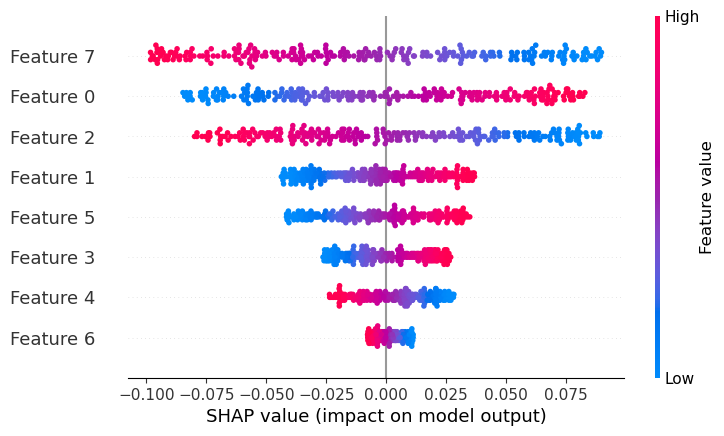

In [18]:
logRegModel = LogisticRegression(penalty='l2', max_iter = 250).fit(X_gen_train, y_gen_train)
explainer = shap.LinearExplainer(logRegModel, X_gen_train)
shap_values = explainer.shap_values(X_gen_train)
bapValues = explainer(X_gen_test)
    
shap.initjs()
shap.plots.beeswarm(bapValues) #this seems to not work do to mutliclass test data

In [36]:
marcoData = np.random.rand(500, 4) + .3 #placeholder. Will be replaced with vectorized marco responses
LLMData = np.random.rand(500, 4)#placeholder. Will be replaced with vectorized LLM resposnes

#------
#wrangling of MARCO data will be here

#------
#wrangling of LLM data will be here

marcoLabels = np.zeros(len(marcoData))
LLMLabels = np.ones(len(LLMData))

realModel = (np.append(marcoData, LLMData)).reshape(len(marcoData)+len(LLMData), len(marcoData[0]))
realClasses = np.append(marcoLabels, LLMLabels)

p = np.random.permutation(len(realModel)) #give it a good shuffle :D
realModel = realModel[p]
realClasses = realClasses[p]

X_response_train, X_response_test, y_origin_train, y_origin_test = train_test_split(realModel, realClasses)

predictedLogReg = generateLogisticRegression(X_response_train,y_origin_train,X_response_test)
predictedBayes = generateNaiveBayes(X_response_train,y_origin_train,X_response_test)

print("logistic metrics on real dataset:")
runMetrics(y_origin_test,predictedLogReg)
print("\naive bayes on real dataset:")
runMetrics(y_origin_test,predictedBayes)


logistic metrics on real dataset:
Precision score of the model: 0.8032786885245902
F1 score of the model 0.8270042194092827
Recall score of the model 0.8521739130434782
AUCROC of the model 0.8371980676328502

aive bayes on real dataset:
Precision score of the model: 0.8032786885245902
F1 score of the model 0.823529411764706
Recall score of the model 0.8448275862068966
AUCROC of the model 0.8328615542974781


[0.8032786885245902, 0.823529411764706, 0.8448275862068966, 0.8328615542974781]